# Zillow Clustering Project
# The Price is Right

In [1]:
import pandas as pd
import numpy as np

# Vis tools
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Modules
import wrangle as w
import explore as ex
import evaluate as ev


# stats and modeling tools
from sklearn.cluster import KMeans
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# supress scientific notation
np.set_printoptions(suppress=True)
#allow for all columns to be displayed in large dataframes
pd.set_option("display.max_columns", None)

# silence warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set and use zillow color palette
zpalette = ['#1277e1', '#f3ad35', '#0b449c', '#5289e4', '#c3eafb']
sns.set_palette(zpalette)
sns.color_palette()

[(0.07058823529411765, 0.4666666666666667, 0.8823529411764706),
 (0.9529411764705882, 0.6784313725490196, 0.20784313725490197),
 (0.043137254901960784, 0.26666666666666666, 0.611764705882353),
 (0.3215686274509804, 0.5372549019607843, 0.8941176470588236),
 (0.7647058823529411, 0.9176470588235294, 0.984313725490196)]


## Project Goals and Ideas
### The Big Question: What is driving the errors in the Zestimates?

For this project the target is `logerror`, may create `abs_logerror` as target instead

#### Goal: Identify Drivers of Error and Create model(s) that account for those drivers.

#### Initial Thoughts
- After only looking at size (bedroom count, bathroom count and square footage for the house itself) model was not great
- Location is very important in real estate. As they say Location Location Location
    - Use Latitude and Longitude to narrow down groups
    - Create clusters of error based on location
    - if that doesn't work, try to use location data and price to create neighborhood clusters  
- Price per square foot is something lots of realtors use for comparing houses that aren't the same size 
    - Create engineered feature, `ppsqft` divide `taxvalue` / `calculatedfinishedsquarefeet` 
- Age of home is important when comparing houses, realtors will compare houses built before 1978, between 1798-2000 and post 2000
    - Create engineered feature age, based on year built
    - Create three bins
- Related to size of home, homes typically get compared with other homes within a 400sqft variance. Possibility here to create size clusters based on `calculatedfinishedsquarefeet`, or `ppsft`, or `lotsize`

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Get the Data and Overview
- Shape of data
- Number unique values
- Distribution of values
- Null Value exploration

In [3]:
# get zillow data with function in wrangle
df = w.get_zillow_data()

In [4]:
# have a total of 77380 rows 46 columns
df.shape

(77380, 46)

In [5]:
# see the names and types of all columns
# Lots of Nulls to deal with
# might need to do some splitting up vx object, float and int
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77380 entries, 0 to 77379
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77380 non-null  int64  
 1   airconditioningtypeid         24953 non-null  float64
 2   airconditioningdesc           24953 non-null  object 
 3   architecturalstyletypeid      206 non-null    float64
 4   architecturalstyledesc        206 non-null    object 
 5   bathroomcnt                   77380 non-null  float64
 6   bedroomcnt                    77380 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingclassdesc             15 non-null     object 
 9   buildingqualitytypeid         49671 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  calculatedfinishedsquarefeet  77184 non-null  float64
 12  fips                          77380 non-null  float64
 13  f

In [6]:
# use overview function to see unique values and value counts
w.overview(df)

============== parcelid ==============
# Unique Vals: 77380

============== airconditioningtypeid ==============
# Unique Vals: 5
1.0     23133
5.0       167
9.0        26
11.0       53
13.0     1574
NaN     52427
Name: airconditioningtypeid, dtype: int64

============== airconditioningdesc ==============
# Unique Vals: 5
Central          23133
None               167
Refrigeration       26
Wall Unit           53
Yes               1574
NaN              52427
Name: airconditioningdesc, dtype: int64

============== architecturalstyletypeid ==============
# Unique Vals: 5
2.0         5
3.0         3
7.0       172
8.0        19
21.0        7
NaN     77174
Name: architecturalstyletypeid, dtype: int64

============== architecturalstyledesc ==============
# Unique Vals: 5
Bungalow             5
Cape Cod             3
Contemporary       172
Conventional        19
Ranch/Rambler        7
NaN              77174
Name: architecturalstyledesc, dtype: int64

============== bathroomcnt ==============
#

#### Takeaways from initial overview
- not sure what roomcnt is and how it's different from bedrooms and bathrooms 
- three quarter bath seems redundant 
- most of the homes here are single family, still need to trim that down
- there's someone who has a 14 car garage (maybe it's a quadruplex or something)
- three houses have 5 fireplaces. Must be really cold there in Southern California
- Date could be changed to a datetime object

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

### Nulls and Outliers
- See where they are and make decisions


In [7]:
w.missing_values_table(df)

Your selected dataframe has 46 columns.
There are 31 columns that have missing values.


,Missing Values,% of Total Values
buildingclasstypeid,77365,100.0
buildingclassdesc,77365,100.0
fireplaceflag,77208,99.8
architecturalstyletypeid,77174,99.7
architecturalstyledesc,77174,99.7
typeconstructiondesc,77158,99.7
typeconstructiontypeid,77158,99.7
decktypeid,76766,99.2
poolsizesum,76513,98.9
hashottuborspa,75842,98.0


In [8]:
w.nulls_by_row(df)

,num_cols_missing,percent_cols_missing,num_rows
0,9,19.57,2
1,10,21.74,10
2,11,23.91,23
3,12,26.09,62
4,13,28.26,114
5,14,30.43,416
6,15,32.61,5577
7,16,34.78,10549
8,17,36.96,14385
9,18,39.13,21032


#### Takeaways from NaNs
- buildingclassdesc and buildingclasstypeid have too many missing, will drop
- fireplaceflag seems to not have been used as much as fireplacecnt (drop fireplaceflag)
- the architectural columns also don't have enough to go on, nothing to replace with
- typeconstructiondesc and typeconstructiontypeid both don't have enough values (these are things like concrete, masonry)
    - This could be interesting later down the road to classify luxury home
- decktypeid, poolsizesum 
- numberofstories doesn't seem like something would be a driver of price 

Turned to 0s 
- hashottuborspa Nan's could be turned to 0s 
- fireplacecnt 
- garagecarcnt can have NaN's converted to 0s 


In [9]:
# after filtering for single family homes there are now 52,429 data points to look at
df = w.single_homes(df)
df.shape

(52429, 46)

In [10]:
# use my function to drop any rows that have more than 85% of the data missing, 
# and any columns that have more than 65% missing

df = w.drop_missing(df)

In [11]:
w.missing_values_table(df)

Your selected dataframe has 24 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
regionidcity,1033,2.0
lotsizesquarefeet,370,0.7
yearbuilt,130,0.2
censustractandblock,115,0.2
calculatedfinishedsquarefeet,98,0.2
structuretaxvaluedollarcnt,88,0.2
taxamount,4,0.0
landtaxvaluedollarcnt,2,0.0
taxvaluedollarcnt,1,0.0


### Nan Takeaways
- Before just outright dropping either more rows, I will dive into feature engineering and dropping outliers to see if this takes care of some of these still missing values
- Then can impute or drop columns all together (I might not need yearbuilt, or regionidcity)
- Right now have 52,426 houses to look at 

## Feature Engineering 
- create `age` and `yearbuilt_bins`
- create `ppsqft` 
- create `county` column from `fips`
- create `taxrate`
- create `abs_logerror` from `logerror`

In [12]:
# functions from wrangle script
# get the age of the home
df = w.get_house_age(df)

# bins for year built
df = w.yearbuilt_bins(df)

# price per squarefoot
df = w.ppsqft(df)

# get county names 
df = w.cali_counties(df)

# calculate the tax rate
df = w.get_tax_rate(df)

# calculate absolute logerror from logerror
df = w.absolute_logerror(df)


### Looking for outliers

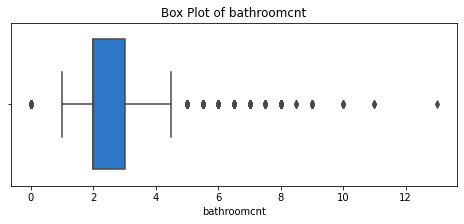

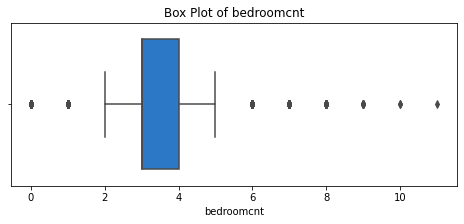

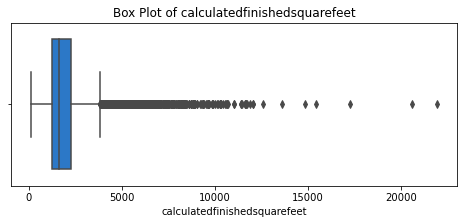

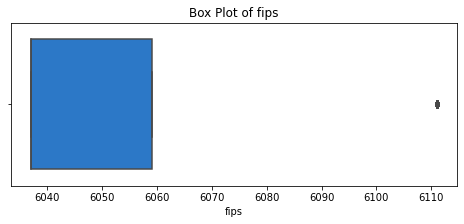

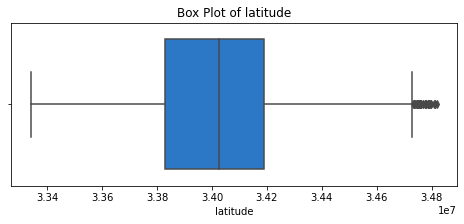

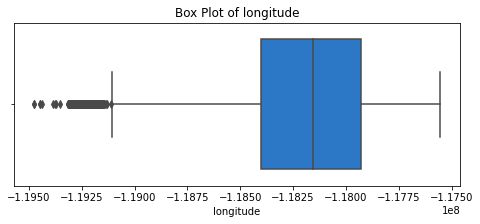

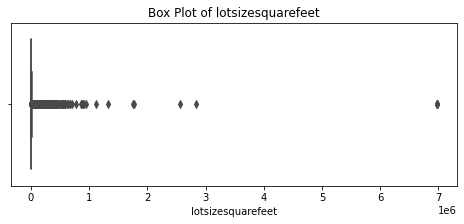

propertycountylandusecode is an object type


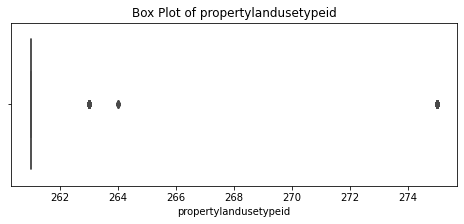

propertylandusedesc is an object type


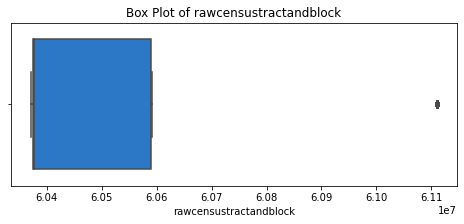

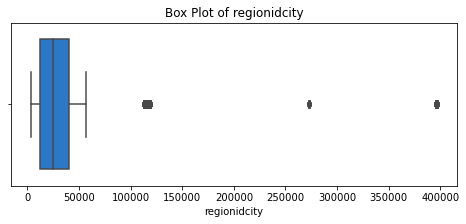

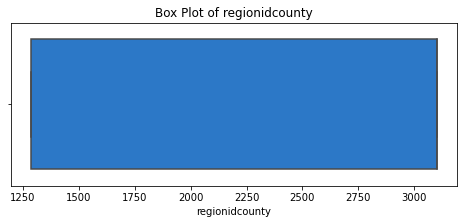

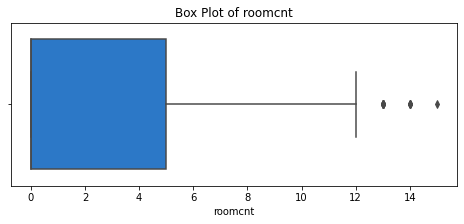

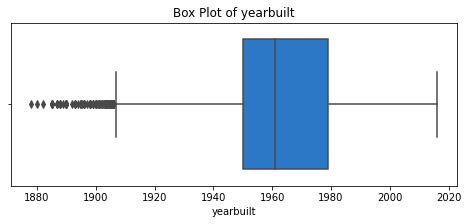

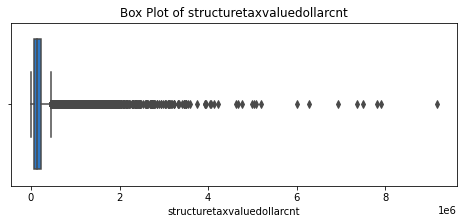

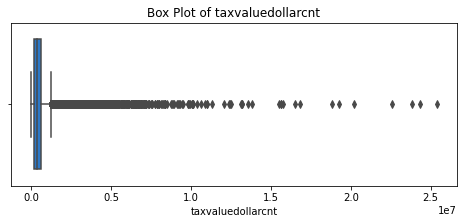

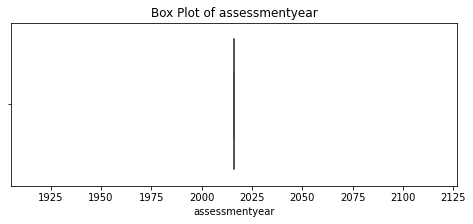

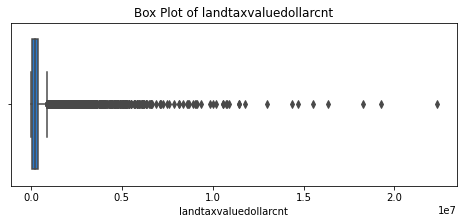

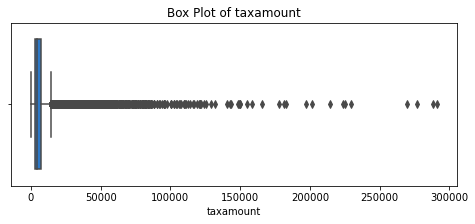

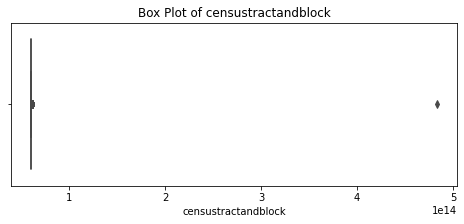

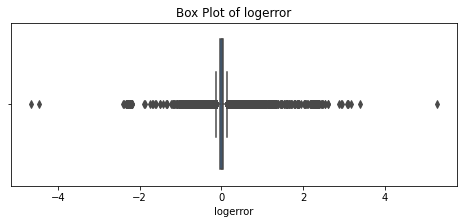

transactiondate is an object type


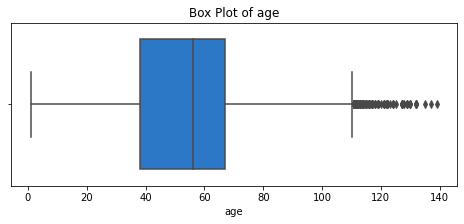

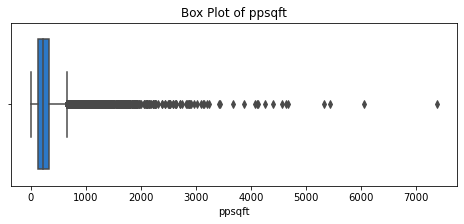

county is an object type


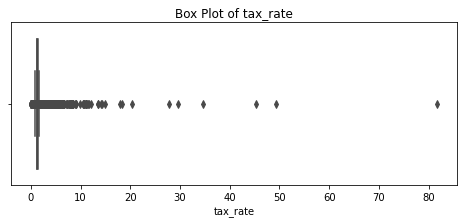

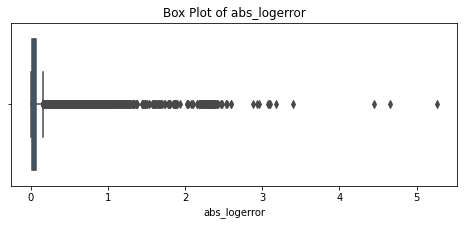

In [13]:
# use function from explore drop parcelid and yearbuilt bins 
ex.plot_boxes(df.drop(columns = ['parcelid', 'yearbuilt_bins']), figsize = (8,3))

### Dealing with outliers
For this project I dropped homes that had:
   - A tax rate higher than 15%
   - A bathroom count higher than 6 or lower than 1
   - A bedroom count higher than 7 or lower than 1

In [14]:
df = w.drop_zillow_outliers(df)

### Dropping unneded columns 
- after feature engineering and dropping outliers decided to outright drop the following columns 
    - `lotsizesquarefeet`, `regionidcity`, `regionidcounty`, `assessmentyear`
    - `regionidcounty` seems to be the same as `fips`, drop it because it's missing values
    - `regionidcity` will drop because location data is captured in lat and long and there's nulls in regionidcity
    - `assessmentyear` isn't of value for this purpose 
- Also dropped rows that had a NaN in a column that had only a few values missing
    - ex. yearbuilt had only 32 NaNs Instead of dropping that entire column, at the very end I dropped those 32 rows instead. 
    - With more time I'd like to work on imputing these values

In [15]:
# all of the above was put into this function
df = w.wrangle_zillow()

In [16]:
df.shape

(51788, 26)

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Explore

- Split data
- Goals explore and make clusters 
- Run stats tests


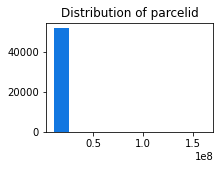

Number of Nulls: 0


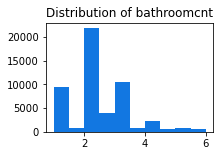

Number of Nulls: 0


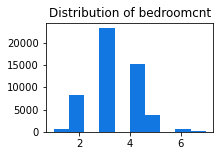

Number of Nulls: 0


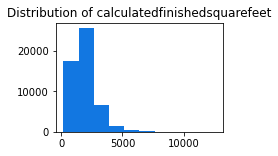

Number of Nulls: 0


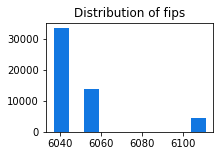

Number of Nulls: 0


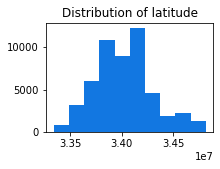

Number of Nulls: 0


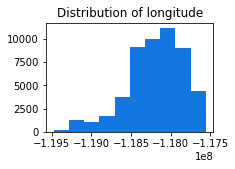

Number of Nulls: 0


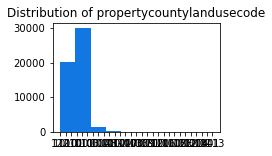

Number of Nulls: 0


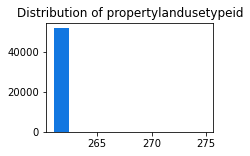

Number of Nulls: 0


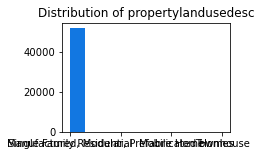

Number of Nulls: 0


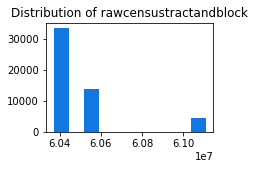

Number of Nulls: 0


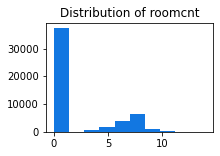

Number of Nulls: 0


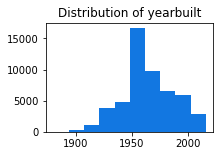

Number of Nulls: 0


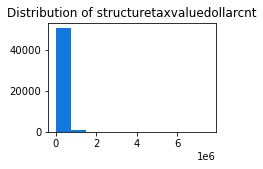

Number of Nulls: 0


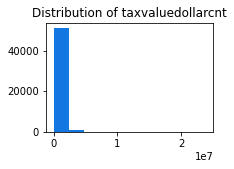

Number of Nulls: 0


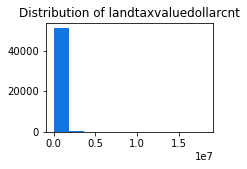

Number of Nulls: 0


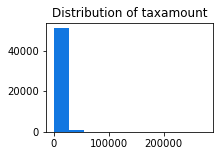

Number of Nulls: 0


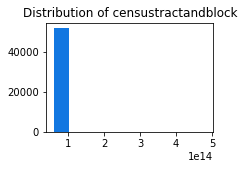

Number of Nulls: 0


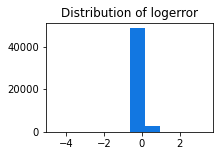

Number of Nulls: 0


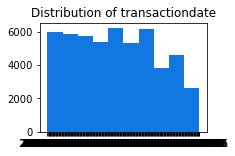

Number of Nulls: 0


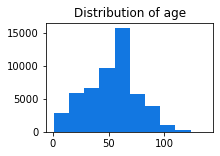

Number of Nulls: 0


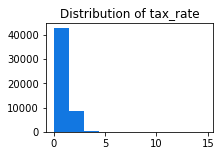

Number of Nulls: 0


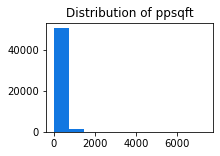

Number of Nulls: 0


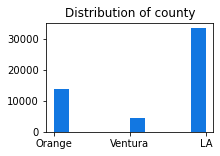

Number of Nulls: 0


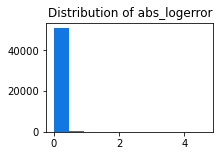

Number of Nulls: 0


In [17]:
ex.plot_variable_dist(df.drop(columns = 'yearbuilt_bins'))

In [18]:
# Set up variables for exploration
target = 'logerror'

target2 = 'abs_logerror'

variables = ['bathroomcnt',
            'bedroomcnt',
            'calculatedfinishedsquarefeet',
            'ppsqft',
            'latitude',
            'longitude',
            'roomcnt',
            'structuretaxvaluedollarcnt',
            'taxvaluedollarcnt',
            'landtaxvaluedollarcnt',
            'taxamount',
            'age',
            'tax_rate']

In [19]:
# split into train validate and test
train, validate, test = w.banana_split(df)

train --> (29001, 26)
validate --> (12429, 26)
test --> (10358, 26)


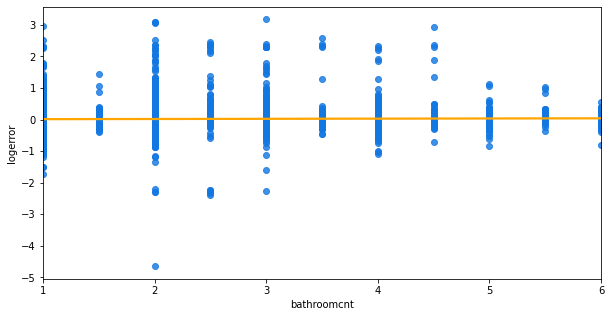

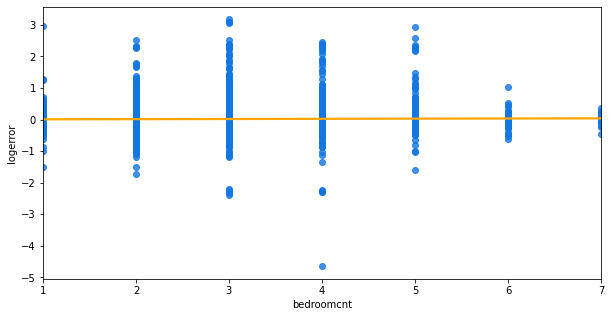

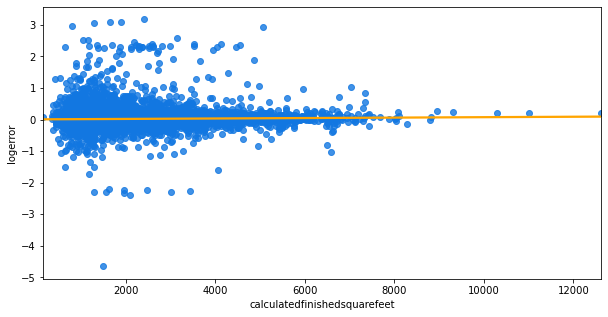

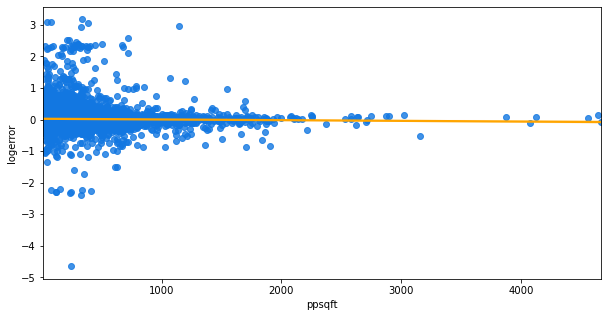

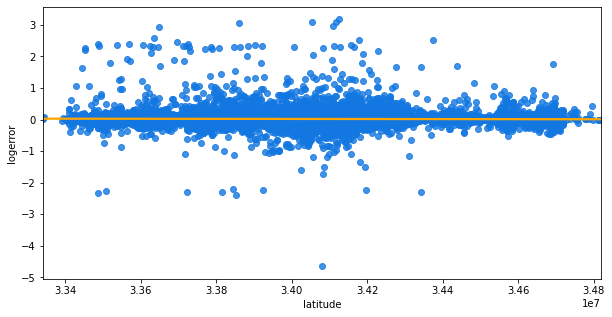

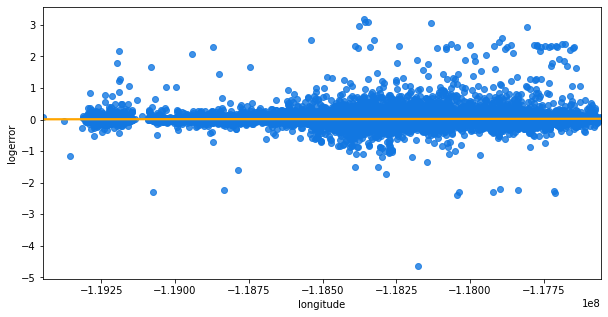

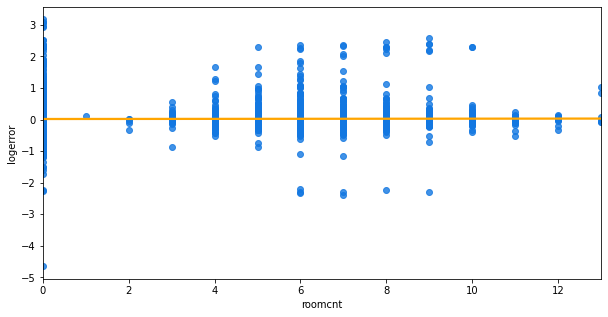

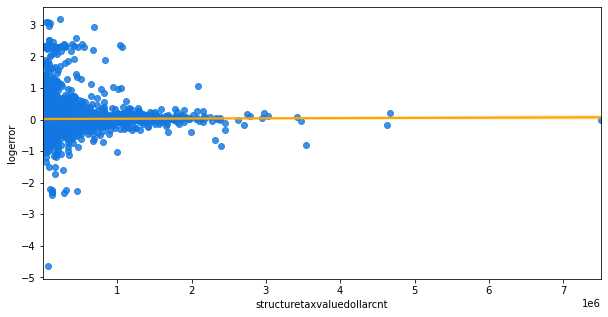

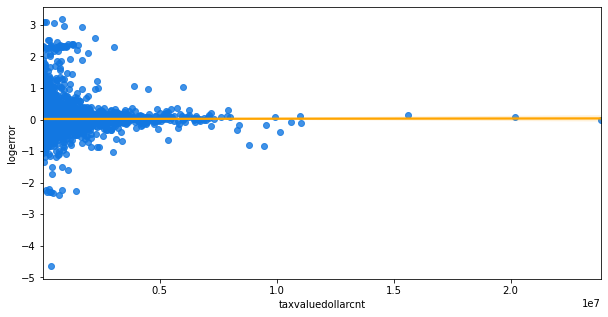

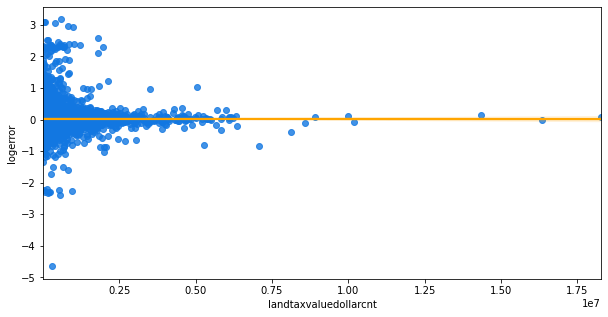

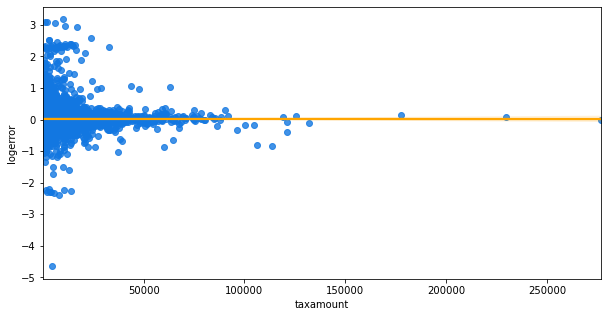

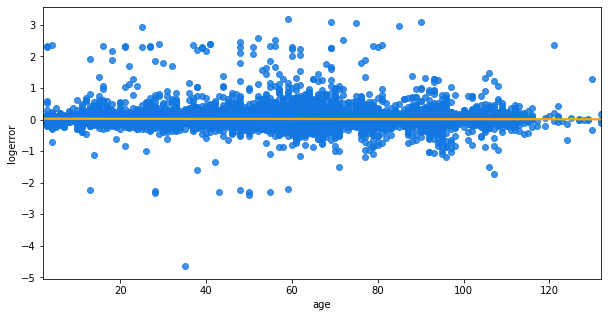

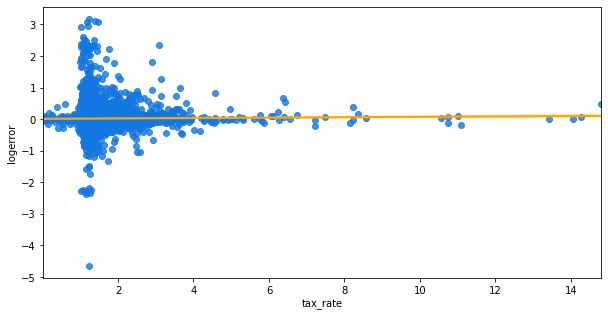

In [20]:
ex.plot_against_target(train, target, variables)

### Takeaways from plotting against target (logerror)
- When taxrate is high, logerror is under guessing
- when taxrate is low, more homes seem to be under guessed 
- Also not very much other info gleaned from this

### Absolute logerror
- Here is where I decided to create this modified target 
- I initially did this to better comprehend what was going on with the data
- I went back up to wrangle and did added a function to calculate the absolute value of the logerror
- With more time I would like to go and create models based on logerror, maybe try to look at when it was high, and when it was low, when it was off by a certain amount.
- However, for the scope of this project I am using absolute logerror as the target

### Takeaways from using abs_logerror
- a lot easier to see where the model is off
- seems to be off more often and larger error when the homes are cheaper and smaller
    - when it has 0 rooms (weird because there are way too many with a 0 in this category) 
        - will drop this column
    - taxrate around 1% (majority of homes are there)
    - when ppsqft is less than 1000 (specifically less than 500)
    - when sqft is around 1500 peak of abs_logerror

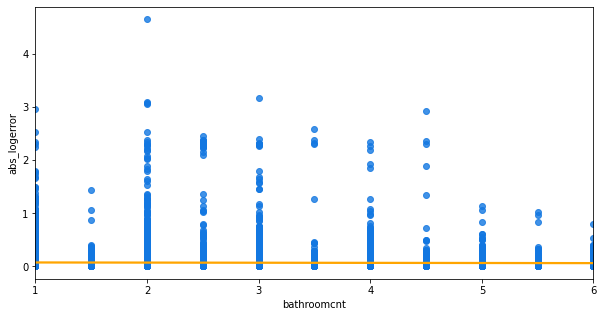

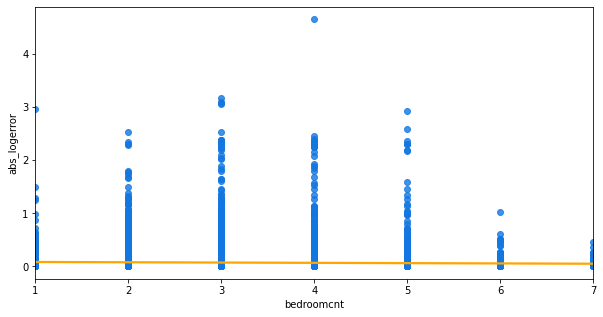

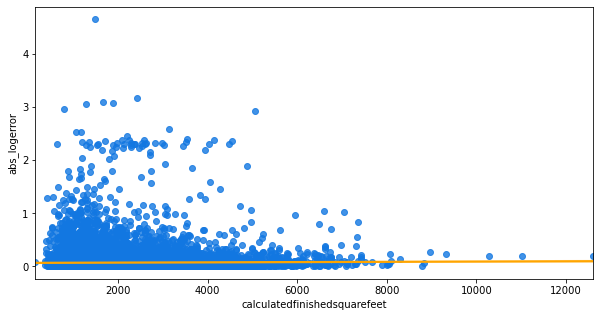

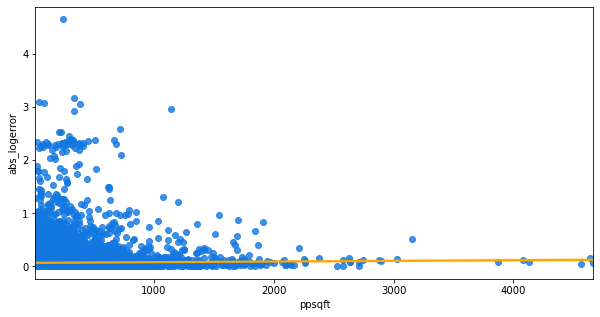

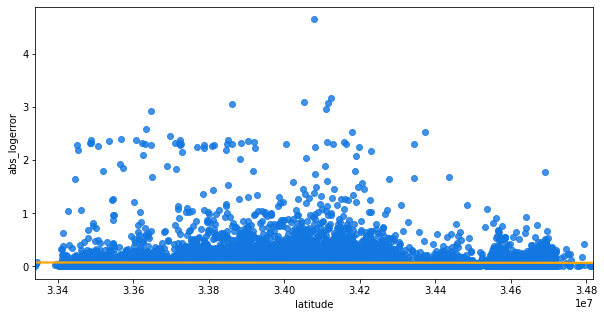

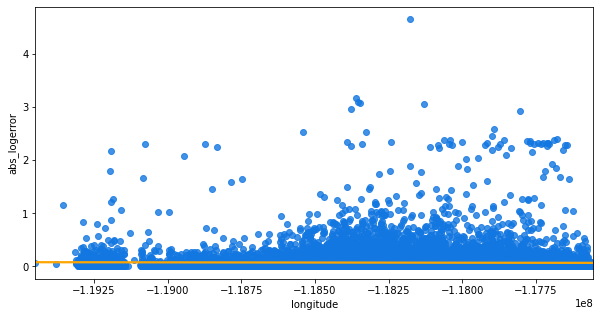

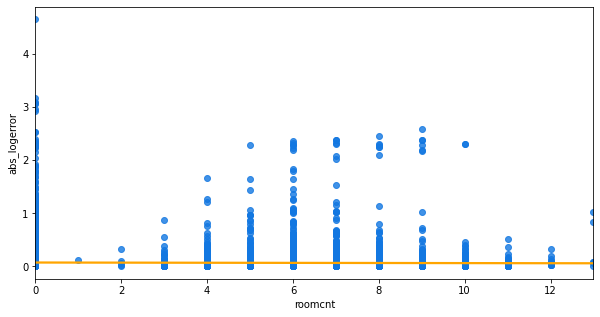

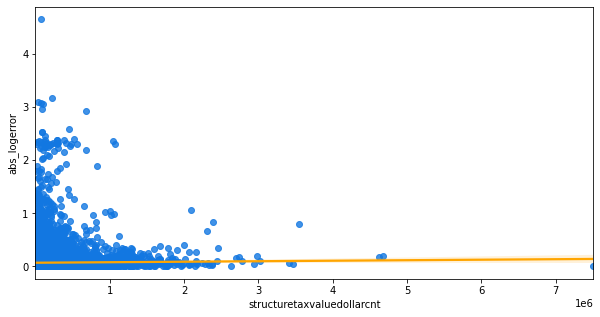

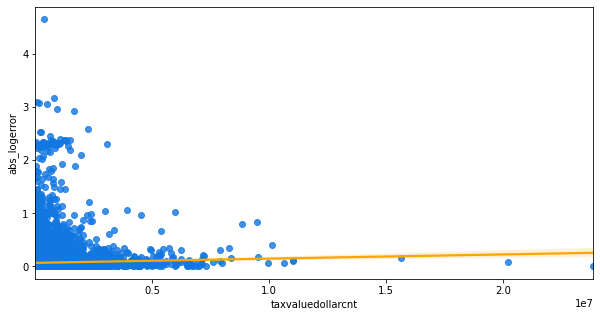

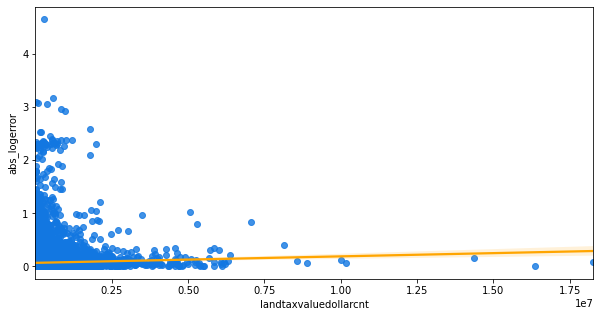

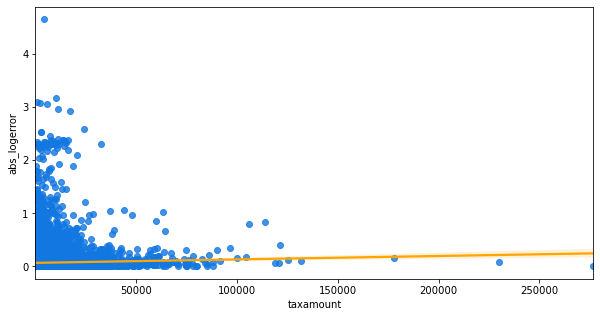

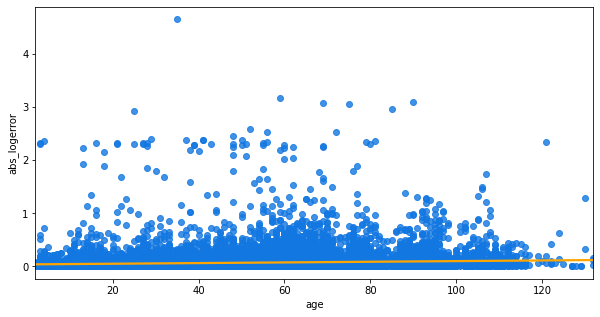

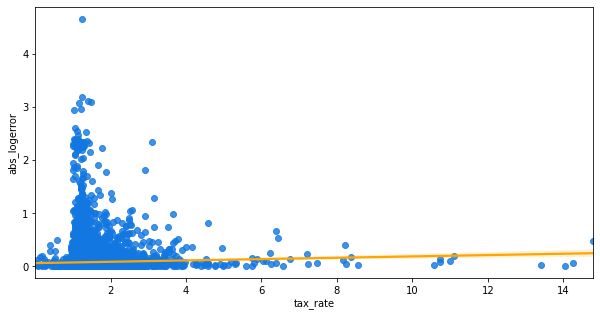

In [21]:
ex.plot_against_target(train, target2 , variables)

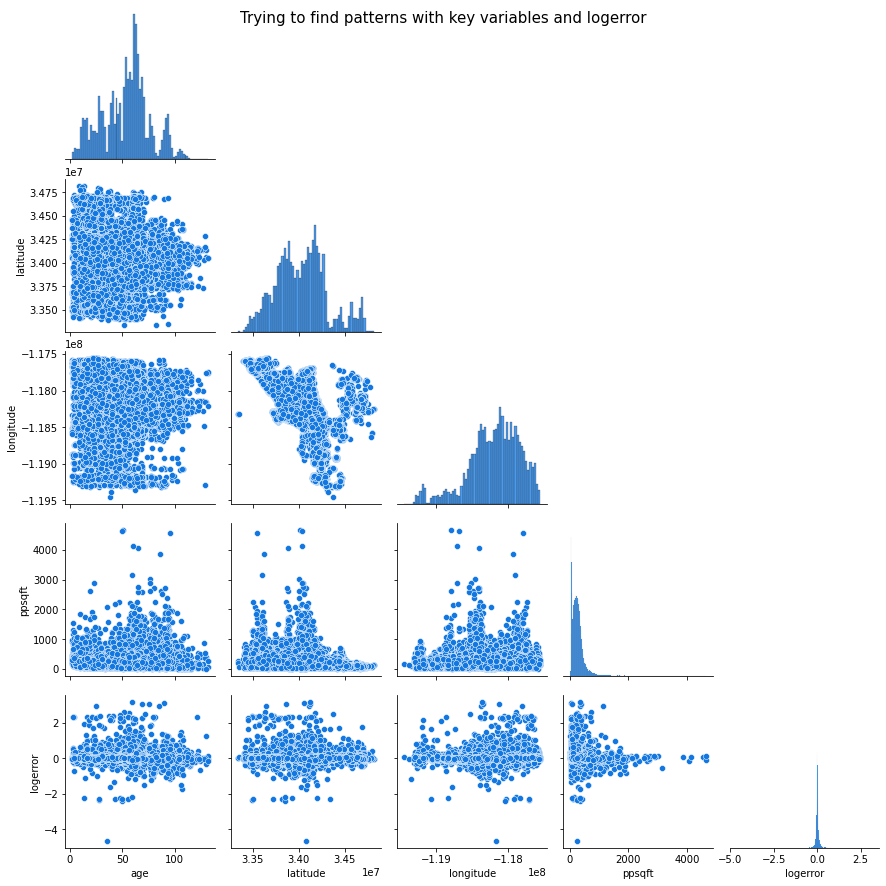

In [22]:
# used small list of columns for pairplot in order to be able to see
cols = ['age', 'latitude', 'longitude', 'ppsqft', 'logerror']

# create pairplot

sns.pairplot(data = train[cols], corner=True)
plt.suptitle('Trying to find patterns with key variables and logerror', fontsize = 15)
plt.show()

### Takeaways from pairplot
- Something weird is going on with `age` and `logerror`
- seems like on the lower end of value log error is high
- Definitely need to cluster log error and lat and long
- wider spread of error on homes under 4000 ish sqft
- Weird errors all the way down on ppsqft and calculated finished sqft
- Looking at the spread 

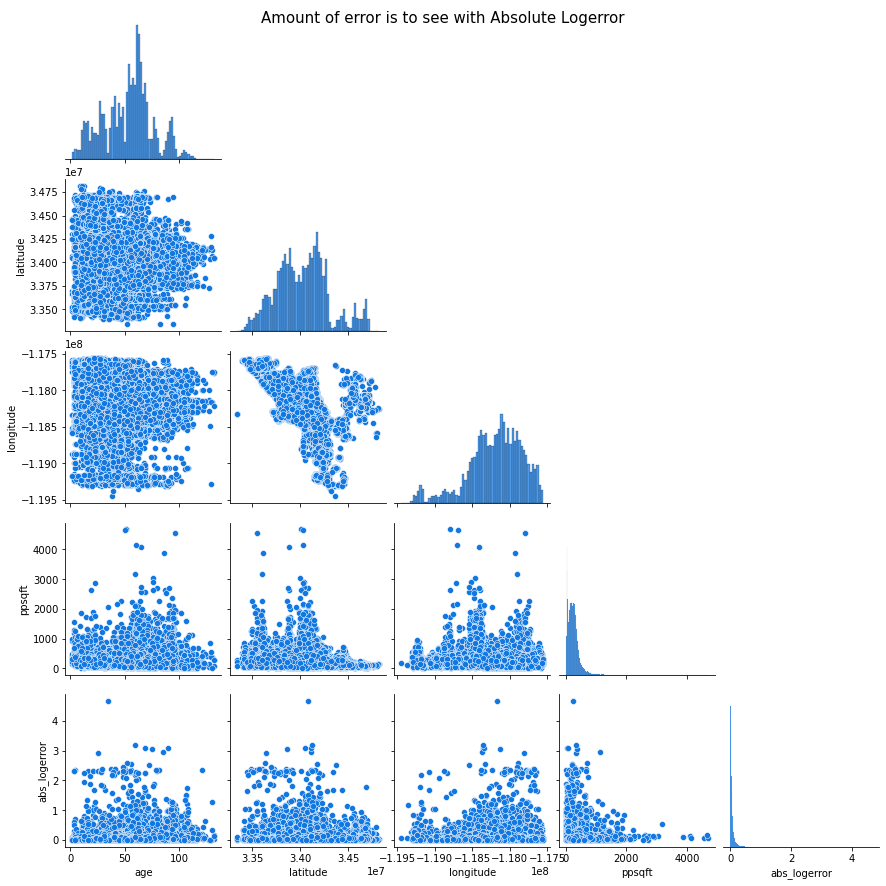

In [23]:
cols = ['age', 'latitude', 'longitude', 'ppsqft', 'abs_logerror']

sns.pairplot(data = train[cols], corner=True)

plt.suptitle('Amount of error is to see with Absolute Logerror', fontsize = 15)

plt.show()

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Clustering 
- Create clusters using lat long and ppsqft 
- Try lat long and age
- Try age and ppsqft 
- Maybe try all 4

#### Cluster 1 (age, latitude, longitude, k = 4)

In [24]:
# set up columns for cluster
X_train = train[['age', 'latitude', 'longitude']]
# scale columns
X_train_scaled, mm_scaler = ex.scale_this(X_train, MinMaxScaler())

In [25]:
X_train_scaled.head()

,age,latitude,longitude
36530,0.092308,0.217877,0.764817
74092,0.407692,0.319770,0.577977
23459,0.453846,0.382821,0.734214
19137,0.461538,0.381763,0.569212
3027,0.461538,0.515441,0.826500


In [26]:
# create kMeans 
X_train_scaled, centroids_scaled, kmeans = ex.makin_clusters(X_train_scaled, 4)

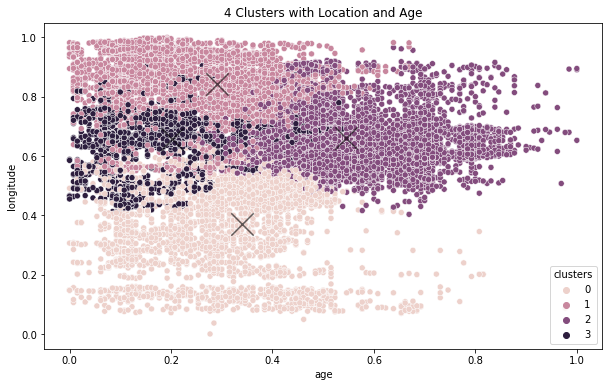

In [27]:
ex.plot_clusters('age', 'longitude', 'clusters', X_train_scaled, kmeans, mm_scaler, centroids_scaled)
plt.title('4 Clusters with Location and Age')
plt.show()

### At first glance:
- My human eyes can't see anything with only plotting the two variables
- Will take a look at inertia to see if I can pick a better number for K

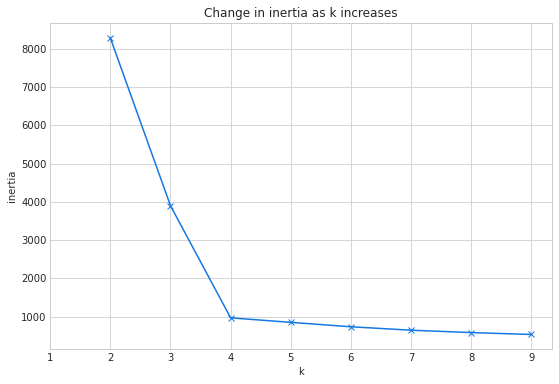

In [28]:
ex.plot_inertia(X_train_scaled)

### Takeaways Inertia
- With the clusters created from latitude, longitude and home age, 4 5 or 6 would seem to work the best. 
- Will try with 5 clusters

#### Clusters 2, (age, latitude, longitude, k = 5)

In [29]:
X_train_scaled, centroids_scaled, kmean = ex.makin_clusters(X_train_scaled, 5)

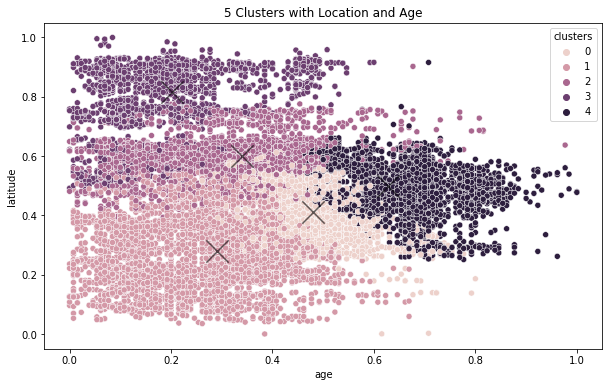

In [30]:
ex.plot_clusters('age', 'latitude', 'clusters', X_train_scaled, kmeans, mm_scaler, centroids_scaled)

plt.title("5 Clusters with Location and Age")
plt.show()

### Takeaways from age location cluster
- not sure if would have value in a model 
- hard to visualize from the graphs here
- Boxplot below doesn't indicate much either
    - There might be some value in cluster 4

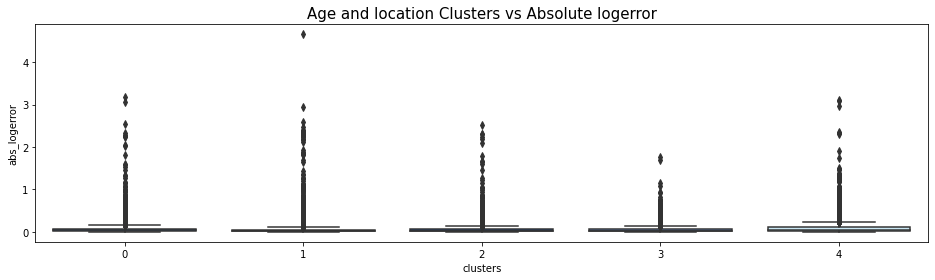

In [31]:
plt.figure(figsize = (16,4))
sns.boxplot(y = train['abs_logerror'], x = X_train_scaled['clusters'])

plt.title('Age and location Clusters vs Absolute logerror', fontsize=15)
plt.show()

### Cluster 3 (latitude, longitude, ppsqft, k = TBD by inertia) 
- the Location Price cluster is what I ended up using as a feature in my model, 
- Here's how it was created

In [32]:
# create new X_train to try with lat long and ppsqft cluster
X_train = train[['latitude', 'longitude', 'ppsqft']]

In [33]:
# scale using minmax
X_train_scaled, mm_scaler = ex.scale_this(X_train, MinMaxScaler())

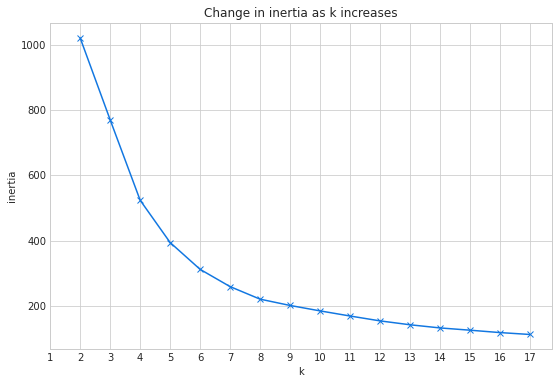

In [34]:
# explore inertia to see where to start
ex.plot_inertia(X_train_scaled, k_range_end=18)

### Takeaways from Inertia 
- With latitude, longitude and ppsqft as variables, will go with 8 clusters 
- I would prefer more clusters but using the elbow method here 8 seems to be the point where inertia decreases but doesn't give us as much value 
- This to me is simulating neighborhood creation (obviously there are many more neighborhoods in reality than 8) 

In [35]:
# create cluster with n = 8
X_train_scaled, centroids_scaled, kmeans = ex.makin_clusters(X_train_scaled, 8)

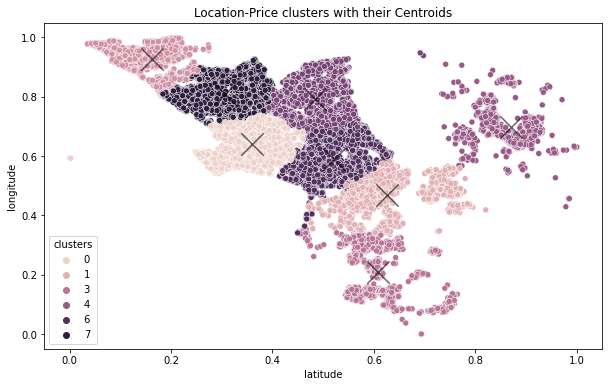

In [36]:
ex.plot_clusters('latitude', 'longitude', 'clusters', X_train_scaled, kmeans, mm_scaler, centroids_scaled)

plt.title("Location-Price clusters with their Centroids")
plt.show()

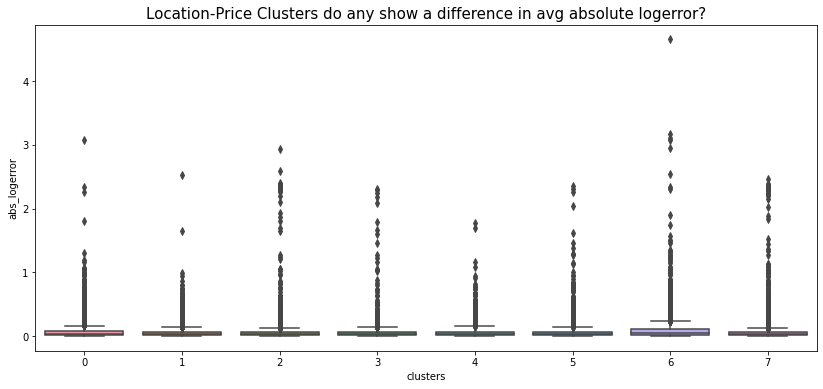

In [37]:
plt.figure(figsize = (14,6))
sns.boxplot(y = train['abs_logerror'], x = X_train_scaled.clusters)

plt.title("Location-Price Clusters do any show a difference in avg absolute logerror?", fontsize = 15)
plt.show()

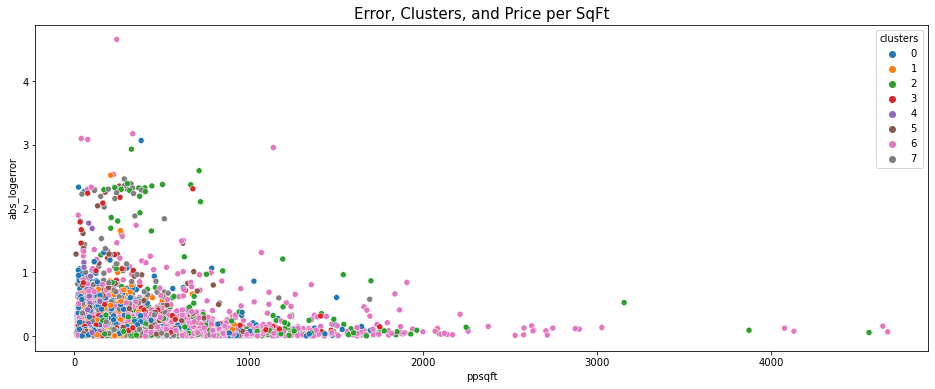

In [38]:
plt.figure(figsize = (16,6))
sns.scatterplot(data = train, y = 'abs_logerror', x = 'ppsqft', hue = X_train_scaled['clusters'], palette='tab10')

plt.title("Error, Clusters, and Price per SqFt", fontsize = 15)
plt.show()

### Takeaways from Location-Price clusters
- Cluster 6 has this large outlier that might be drawing the mean up
- Cluster 7 has some significant outliers as well (abs_logerror above 4
- The purple cluster (number 4) seems to have the lowest amount of high logerror homes

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Exploring and Stats testing with Clusters
- In order to explore with my clusters, I would now need to scale my data to prep with modeling
- I added my clusters to the data frames with the name `locationprice_cluster` 
- Scaled all my data
- And created dummy variables for categorical variables, including clusters
- All of this is in my wrangle_pt2 function

In [3]:
# data is now scaled and split into dummies appropriately
train, validate, test, mm_scaler = w.wrangle_pt2()

train --> (29001, 16)
validate --> (12429, 16)
test --> (10358, 16)


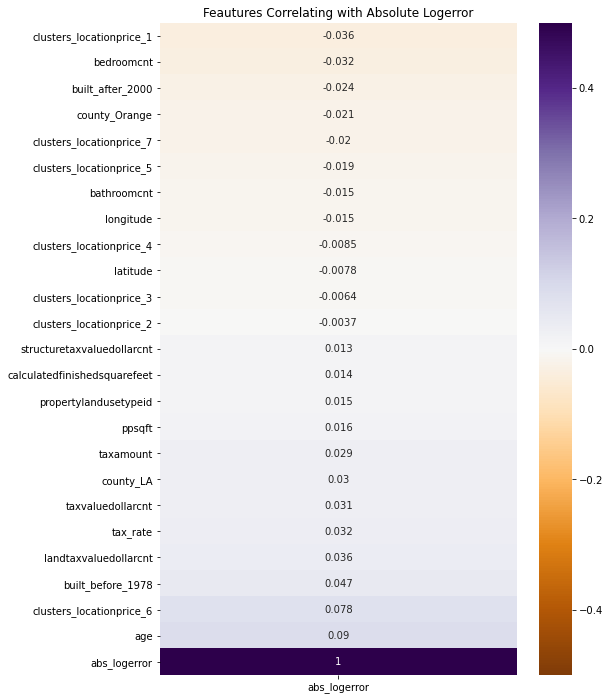

In [40]:
# create heatmap with scaled data
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train.corr()[['abs_logerror']].sort_values(by='abs_logerror', ascending=True), 
                            cmap='PuOr', vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Absolute Logerror')
plt.show()

### Takeaways from Heatmap
- Older the house, higher the error
- Cluster_locationprice number 6 has a pretty high error 
- All of the age related columns 
- Age seems to be a driver more so than location
- With more time: Try creating more location based clusters

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Stats Testing
Questions I have:
- Do Age and abs log error have a linear relationship?
- Does cluster locationprice group 6 have a relationship with abs log error (one sample, t_test)
    - is the mean lower 
- Built before 1978 
- 6 vs 7 ind ttest
- Is there a relationship between taxvaluedollarcnt and abs_logerror

### Cluster Tests
------
${H_0}$: mean log error of cluster 6 == to mean absolute log error

${H_a}$: mean log error of cluster 6 != to mean absolute log error

alpha = 0.05


In [42]:
t, p = stats.ttest_1samp(train[train.clusters_locationprice_6 == 1].abs_logerror, train['abs_logerror'].mean() )

In [43]:
t, p 

(10.065582698020648, 1.3651897508564518e-23)

### P is less than our alpha, can reject null hypothesis that mean abs_logerror of clusters_locationprice_6 are the same. Evidence to suggest they're different. Seems (because of the positive t) mean error is higher with this group

- I don't think all the clusters are as relevant
- Quick test with cluster 4 just to see.
    - alpha = 0.05

In [44]:
t, p = stats.ttest_1samp(train[train.clusters_locationprice_4 == 1].abs_logerror, train['abs_logerror'].mean() )

In [45]:
t, p

(-1.8729716867919277, 0.06121178300153992)

#### P is not less than alpha for clusters_locationprice_4, suggesting this clusters mean logerror one isn't far off from group as a whole mean log error 

### Age tests
#### One using the age variable (which is continuous) and once using the before 1987 binned category 
- could also compare two subgroups, before 1987 and after 1987

-----

${H_0}$: The mean abs_logerror for homes built before 1987 is == to the mean abs_logerror for all homes

${H_a}$:The mean abs_logerror for homes built before 1987 is != to the mean abs_logerror for all homes

alpha = 0.05

test = independent T-Test

In [46]:
t, p = stats.ttest_1samp(train[train.built_before_1978 == 1].abs_logerror, train['abs_logerror'].mean())
print(f't = {t}, p = {p}')

t = 4.09721399636987, p = 4.196793540484116e-05


#### Because our P is less than our alpha, can reject null hypothesis that the mean abs_logerror for homes built before 1987 is statistically different than the mean abs_logerror for the whole population

-----

${H_0}$: There is no linear correlation between age of the home and absolute logerror

${H_a}$:There is a linear correlation between age of the home and absolute logerror

alpha = 0.05

test = Pearson R

In [47]:
r, p = stats.pearsonr(train['age'], train['abs_logerror'])
print(f'r = {r}, p = {p}')

r = 0.08964199485797082, p = 8.144295793820683e-53


#### The p is less than our alpha, we can reject the null hypothesis. There is evidence to suggest that the linear correlation between age and abs_logerror is statistically significant.

-----

### Tax Value and Log error

${H_0}$: There is no linear relationship between Home Value (taxvaluedollarcnt) and absolute logerror 

${H_a}$: There is a linear relationship between Home Value (taxvaluedollarcnt) and absolute logerror

alpha = 0.05

test = Pearson R

In [48]:
r, p = stats.pearsonr(train['taxvaluedollarcnt'], train['abs_logerror'])
print(f'r = {r}, p = {p}')

r = 0.030870564451880626, p = 1.454842536162954e-07


#### P value is less than the alpha, so we can reject the null hypotheses. There is evidence to suggest that the linear correlation between age and absolute logerror is statistically significant. 

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Modeling
**Create Basline based off of the Mean absolute logerror**
   - The RMSE for predicting the mean: 0.1584
   - This might be a pretty decent model. We'll see if we can get lower
   - If baseline was using just logerror this would be the mean
       - 0.0166
   - When we use absolute logerror, mean is
       - 0.0688
**Things to Try:**
- Try a generic model with my clusters and features included
    - Is it better than the baseline?
- Try several models based on age (using bins perhaps)
    - Do these models perform better than the baseline? or better than the generic model from before?

In [6]:
# add the baseline predictions to train validate and test
train, validate, test = ev.get_mean_baseline(train, validate, test)

### Single Model goals
 - Generic Model with all features (clusters included) to see how it does
     - use OLM
     - Use Lasso Lars

### Model 1 - OLM 1

In [7]:
# get list of columns to use in X_train by dropping abs_logerror and baseline columns
X_cols = list(train.drop(columns = ['abs_logerror', 'baseline']))
y_col = 'abs_logerror'

In [8]:
# split in to X and y dfs
X_train, y_train, X_validate, y_validate, X_test, y_test = w.all_aboard_the_X_train(X_cols, y_col, train, validate, test)

In [9]:
ev.regression_modeler_for_validating(X_cols, y_col, train, validate, model = LinearRegression(), model_name = 'olm_1')

olm_1 has been created and added to train and validate dataframes

train RMSE for olm_1: 0.15674041397092733 
validate RMSE for olm_1: 0.14422316307752708 


In [10]:
ev.compare_to_basline(train, y_train, 'olm_1', 'train')

------- train ---------

RMSE for olm_1: 0.15674041397092733

RMSE for baseline: 0.1583854865826303

Better than baseline?: True by 0.0016450726117029635
        


In [11]:
ev.compare_to_basline(validate, y_validate, 'olm_1', 'validate')

------- validate ---------

RMSE for olm_1: 0.14422316307752708

RMSE for baseline: 0.14559851923806527

Better than baseline?: True by 0.001375356160538188
        


### Takeaways OLM Model 1
- Better than the baseline by 0.002 on the RMSE on both seen and unseen data
- Pretty decent as a first model will continue to see if I can be better

### Model 2 Lasso Lars
- use all the variables and crate a lasso lars models
- adjust alpha by tiny amounts (0.00001)

In [12]:
ev.regression_modeler_for_validating(X_cols, y_col, train, validate, model = LassoLars(alpha = 0.00001), model_name='lars_1')

lars_1 has been created and added to train and validate dataframes

train RMSE for lars_1: 0.157069765292894 
validate RMSE for lars_1: 0.14435077696060825 


In [13]:
ev.compare_to_basline(train, y_train, 'lars_1', 'train')

------- train ---------

RMSE for lars_1: 0.157069765292894

RMSE for baseline: 0.1583854865826303

Better than baseline?: True by 0.0013157212897363102
        


In [14]:
ev.compare_to_basline(validate, y_validate, 'lars_1', 'validate')

------- validate ---------

RMSE for lars_1: 0.14435077696060825

RMSE for baseline: 0.14559851923806527

Better than baseline?: True by 0.0012477422774570257
        


### Takeaways Lars Model 1
- better than baseline by 0.001
- not as good as the first OLM model
- will try again adjusting the alpha some more

### Model 3 Lasso Lars (2)
- this model will be different from above by adjusting the alpha some more

In [15]:
ev.regression_modeler_for_validating(X_cols, y_col, train, validate, model = LassoLars(alpha = 0.000001), model_name='lars_2')

lars_2 has been created and added to train and validate dataframes

train RMSE for lars_2: 0.15680050047556393 
validate RMSE for lars_2: 0.14420181472401813 


In [16]:
ev.compare_to_basline(train, y_train, 'lars_2', 'train')

------- train ---------

RMSE for lars_2: 0.15680050047556393

RMSE for baseline: 0.1583854865826303

Better than baseline?: True by 0.0015849861070663662
        


In [17]:
ev.compare_to_basline(validate, y_validate, 'lars_1', 'validate')

------- validate ---------

RMSE for lars_1: 0.14435077696060825

RMSE for baseline: 0.14559851923806527

Better than baseline?: True by 0.0012477422774570257
        


### Takeaways Lasso Lars Model 2
- tweaking the alpha doesn't do as much

### Models with age 
Try several models based on age (using bins perhaps)
   - Do these models perform better than the baseline? or better than the generic model from before?
Create models on subsets of the data
- 3 models, one for each bin of the age data
    - DISCOVERED: not enough data in validate to do three bins, will to two
    - one before 1987 and one after
- will use OLM because it was the best in the ones before

In [18]:
#split into 3 dataframes for old middle new homes

train_old, train_new = ev.old_new(train)

validate_old, validate_new = ev.old_new(validate)

test_old, test_new = ev.old_new(test)


In [19]:
# split into X_train and y_train and X_validate and y_validate for old and new

X_train_o, y_train_o, X_validate_o, y_validate_o, X_test_o, y_test_o = w.all_aboard_the_X_train(X_cols, y_col, train_old, validate_old, test_old)

X_train_n, y_train_n, X_validate_n, y_validate_n, X_test_n, y_test_n = w.all_aboard_the_X_train(X_cols, y_col, train_new, validate_new, test_new)



In [20]:
# create models for old homes

ev.regression_modeler_for_validating(X_cols, y_col, train_old, validate_old, model_name= 'olm_1')


olm_1 has been created and added to train and validate dataframes

train RMSE for olm_1: 0.15608093589001712 
validate RMSE for olm_1: 0.14840571211800296 


In [21]:
ev.compare_to_basline(train_old, y_train_o, 'olm_1', 'train_old')

------- train_old ---------

RMSE for olm_1: 0.15608093589001712

RMSE for baseline: 0.15783651958169828

Better than baseline?: True by 0.0017555836916811618
        


In [22]:
ev.compare_to_basline(validate_old, y_validate_o, 'olm_1', 'validate_old')

------- validate_old ---------

RMSE for olm_1: 0.14840571211800296

RMSE for baseline: 0.149654734647755

Better than baseline?: True by 0.0012490225297520363
        


In [23]:
# create model for newer homes 

ev.regression_modeler_for_validating(X_cols, y_col, train_new, validate_new, model_name= 'olm_1')


olm_1 has been created and added to train and validate dataframes

train RMSE for olm_1: 0.15790138309792975 
validate RMSE for olm_1: 0.13061151104650945 


In [24]:
ev.compare_to_basline(train_new, y_train_n, 'olm_1', 'train_new')

------- train_new ---------

RMSE for olm_1: 0.15790138309792975

RMSE for baseline: 0.15996944580328298

Better than baseline?: True by 0.0020680627053532297
        


In [25]:
ev.compare_to_basline(validate_new, y_validate_n, 'olm_1', 'validate_new')

------- validate_new ---------

RMSE for olm_1: 0.13061151104650945

RMSE for baseline: 0.13290446553839078

Better than baseline?: True by 0.002292954491881327
        


### Takeaways Modeling with Age
- After taking out the homes before 1978, and creating two separate models, both train and validate had a 0.002 improvement over the baseline using an olm model
- The model for new homes seem to be performing better. 

## Choosing the best model

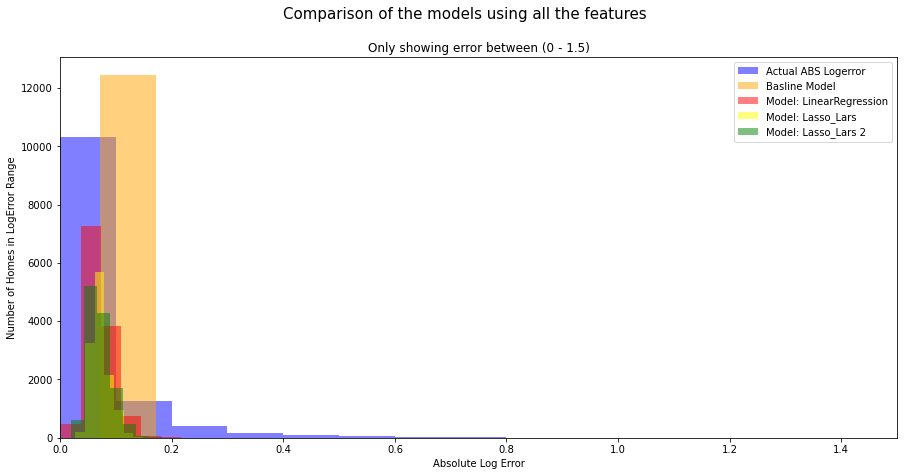

In [40]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(15,7))
plt.hist(validate['abs_logerror'], color='blue', alpha=.5, label="Actual ABS Logerror", 
         bins=[0, .1, .2, .3, .4, .5, .6, .7, .8])
plt.hist(validate['baseline'], color='orange', alpha=.5, label="Basline Model")
plt.hist(validate['olm_1'], color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(validate['lars_1'], color='yellow', alpha=.5, label="Model: Lasso_Lars")
plt.hist(validate['lars_2'], color='green', alpha=.5, label="Model: Lasso_Lars 2")
plt.suptitle("Comparison of the models using all the features", fontsize = 15)
plt.title("Only showing error between (0 - 1.5)")
plt.xlabel("Absolute Log Error")
plt.ylabel("Number of Homes in LogError Range")
plt.xlim(left = 0, right = 1.5)
plt.legend()
plt.show()

In [32]:
validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12429 entries, 37121 to 73257
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   12429 non-null  float64
 1   bedroomcnt                    12429 non-null  float64
 2   calculatedfinishedsquarefeet  12429 non-null  float64
 3   latitude                      12429 non-null  float64
 4   longitude                     12429 non-null  float64
 5   propertylandusetypeid         12429 non-null  float64
 6   structuretaxvaluedollarcnt    12429 non-null  float64
 7   taxvaluedollarcnt             12429 non-null  float64
 8   landtaxvaluedollarcnt         12429 non-null  float64
 9   taxamount                     12429 non-null  float64
 10  age                           12429 non-null  float64
 11  tax_rate                      12429 non-null  float64
 12  ppsqft                        12429 non-null  float64
 1

**None of the Models Did particularly well**
- Although taking out the old homes, and just creating a model for the new homes, performed the best (beating the baseline RMSE by .0022 on unseen data), the model for the older homes didn't do as well. With more time I would tweak that model maybe using lasso lars or polynomial regression to make that work better
- Because that one was incomplete, the second best model was the Linear Regression using all the features (model 1) 
- Outscoring the baseline by 0.0013 on the unseen data
- As evident by the graph, there is not a huge difference in the predictive value of the models created

In [27]:
ev.regression_modeler_for_TEST(X_cols, y_col, train, validate, test, model_name = 'olm_1' )


olm_1 has been created and added to train and validate dataframes

train RMSE for olm_1: 0.15674041397092733 
validate RMSE for olm_1: 0.14422316307752708 


In [30]:
ev.compare_to_basline(test, test[y_col], 'olm_1', 'test')

------- test ---------

RMSE for olm_1: 0.17091000643430998

RMSE for baseline: 0.1722163047705485

Better than baseline?: True by 0.0013062983362385205
        


<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

# Conclusion
- The models were not very effective but did out perform the baseline
- There was some value in the clusters created from Location and Price
- With some more time I would like to 
    - Create more clusters using age and price to see if I can find a driver there
    - Create some polynomial regression models 
    - Dig deep into the older homes model and see if I can make that better
